In [205]:
#Import all libraries
import pandas as pd
import numpy as np
import pickle

In [206]:
#Reading data and printing shape
df_size = pd.read_csv('penguins.csv', sep=',')
df_size.shape

(344, 8)

In [207]:
#Dropping na records
df = df_size.dropna()
df.reset_index(drop=True)
df.shape

(333, 8)

In [208]:
#Dropping year, as it does not add any significance to the dataset
df = df.drop('year', axis=1)
df.reset_index(drop=True)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male
...,...,...,...,...,...,...,...
328,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male
329,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female
330,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male
331,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male


In [209]:
#Converting the sex column to binary
df['sex'].replace(['male', 'female'],
                        [0, 1], inplace=True)

In [211]:
df.reset_index(drop=True)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,1
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,1
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,0
...,...,...,...,...,...,...,...
328,Chinstrap,Dream,55.8,19.8,207.0,4000.0,0
329,Chinstrap,Dream,43.5,18.1,202.0,3400.0,1
330,Chinstrap,Dream,49.6,18.2,193.0,3775.0,0
331,Chinstrap,Dream,50.8,19.0,210.0,4100.0,0


In [212]:
#Isolating numerical and categorical columns
df_x = df.drop(["sex","species","island"], axis=1)
df_x = df_x.apply(lambda x: ((x - x.min())/(x.max() - x.min())).round(2))
df_y = df["sex"]
df_cat = df[["species","island"]]
df_cat

,species,island
0,Adelie,Torgersen
1,Adelie,Torgersen
2,Adelie,Torgersen
4,Adelie,Torgersen
5,Adelie,Torgersen
...,...,...
339,Chinstrap,Dream
340,Chinstrap,Dream
341,Chinstrap,Dream
342,Chinstrap,Dream


In [213]:
#One hot encoding the categorical columns and combining them into one input data
df_x_encoded = pd.get_dummies(df_cat,drop_first=True)
df_final = pd.concat([df_x_encoded, df_x[df_x.columns.difference(["sex","species","island"])]], axis=1)
df_final.reset_index(drop=True)
df_final.columns

Index(['species_Chinstrap', 'species_Gentoo', 'island_Dream',
       'island_Torgersen', 'bill_depth_mm', 'bill_length_mm', 'body_mass_g',
       'flipper_length_mm'],
      dtype='object')

In [214]:
#Splitting the data into test and training dataset
X_train = df_final.sample(frac=0.8,random_state=200)
print(X_train.shape)
X_test = df_final.drop(X_train.index)
print(X_test.shape)
y_train = df_y.sample(frac=0.8,random_state=200)
print(y_train.shape)
y_test = df_y.drop(y_train.index)
print(y_test.shape)


(266, 8)
(67, 8)
(266,)
(67,)


In [215]:
#Creating a function for calculating accuracy of the model
def accuracy(y_test,pred2):
    try:
        return np.mean(np.array([ 1 if x==y else 0 for x,y in zip(pred2,y_test) ]))
    except Exception as msg:
            print(msg)

In [216]:
#Creating a class with all the functions for logistic regression
class LogitRegression:

    def __init__(self,learning_rate, iterations):
        #Assigning LR and iterations to self
        self.learning_rate = learning_rate
        self.iterations = iterations
        
    def sigmoid(self,z):
        #Activation function for the model
        return np.array([(1 / (1+ np.exp(-1*value))) for value in z])
    
    def cost(self,dx,dy):
        #Calculating the loss of the model
        try:
            x_dot_weights = np.matmul(self.weights, dx.transpose()) + self.bias
            pred = self.sigmoid(x_dot_weights)
            J = (1/dy.shape[0])*np.sum(((-1*dy*np.log(pred))-((1-dy)*np.log(1-pred))))
        except Exception as msg:
            print(msg)
        return J
    
    def gradient_descent(self,dx,dy):
        #optimization algorithm which is commonly-used to train machine learning models
        x_dot_weights = np.matmul(self.weights, dx.transpose()) + self.bias
        pred = self.sigmoid(x_dot_weights)
        difference =  pred - dy
        gradient_b = np.mean(difference)
        gradients_w = np.matmul(dx.transpose(), difference)
        gradients_w = np.array([np.mean(grad) for grad in gradients_w])
        self.weights = self.weights - self.learning_rate * gradients_w
        self.bias = self.bias - self.learning_rate * gradient_b

    def fit(self,dx,dy):
        #Fitting the training dataset with the model
        self.bias = 0
        self.loss = []
        self.weights = np.random.uniform(0, 1,dx.shape[1])
        for ele in range(self.iterations):
            self.gradient_descent(dx, dy)
            loss = self.cost(dx, dy)
            self.loss.append(loss)
            
    def predict(self, x):
        #Predicting the test dataset based on the trained model
        x_dot_weights = np.matmul(x, self.weights.transpose()) + self.bias
        probabilities = self.sigmoid(x_dot_weights)
        return [1 if p > 0.5 else 0 for p in probabilities]

[  1.99416989   8.38801473   1.91509748   1.44511755   3.19201642
  -6.58585099 -11.92291118   2.38063682]
0.835820895522388


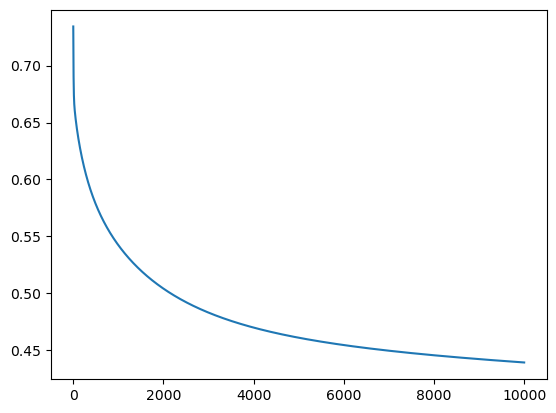

In [221]:
#Building model by trial 1 with the following hyper parameter
learning_rate = 0.001
iterations = 10000
model = LogitRegression(learning_rate, iterations)
model.fit(X_train, y_train)
pred2 = model.predict(X_test)
x = accuracy(y_test,pred2)
print(model.weights)
print(x)

plt.plot(model.loss)
plt.show()

[  2.77353057   7.92001355   1.27846803   0.85451259   0.45999458
  -8.47157489 -13.15798129   2.04320762]
0.8507462686567164


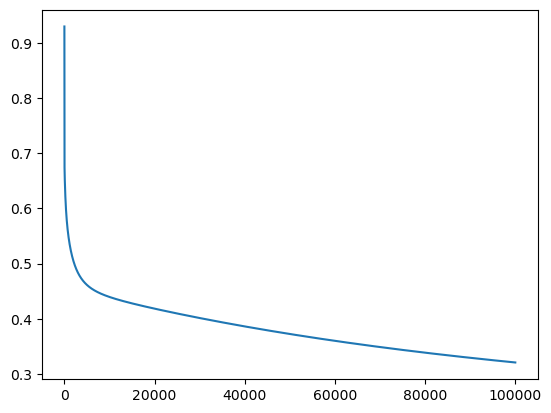

In [222]:
#Building model by trial 2 with the following hyper parameter
learning_rate = 0.001
iterations = 100000
model = LogitRegression(learning_rate, iterations)
model.fit(X_train, y_train)
pred2 = model.predict(X_test)
x = accuracy(y_test,pred2)
print(model.weights)
print(x)

plt.plot(model.loss)
plt.show()

[  7.15209197   7.46578303   0.2020781   -0.15347993 -14.1458226
 -19.59894291 -21.01923608   1.61823988]
0.9253731343283582


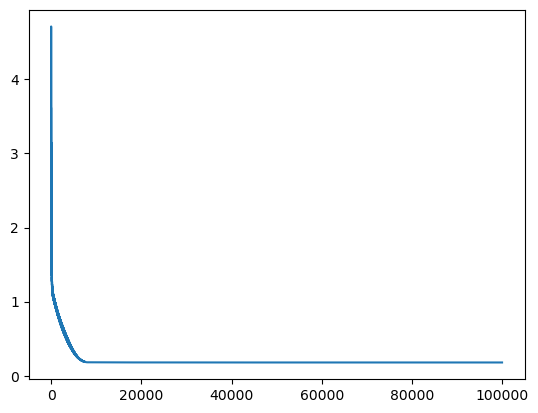

In [223]:
#Building model by trial 3 with the following hyper parameter
learning_rate = 0.1
iterations = 100000
model = LogitRegression(learning_rate, iterations)
model.fit(X_train, y_train)
pred2 = model.predict(X_test)
x = accuracy(y_test,pred2)
print(model.weights)
print(x)

plt.plot(model.loss)
plt.show()

In [224]:
#Saving the model weights in pickle file
with open('dmohanra_zemingzh_assignment1_part1.pickle','wb') as file:
   pickle.dump(model.weights,file)

In [225]:
#Retrieving the model weights from the pickle file to validate
with open('dmohanra_zemingzh_assignment1_part1.pickle','rb') as file:
    print(pickle.load(file))

[  7.15209197   7.46578303   0.2020781   -0.15347993 -14.1458226
 -19.59894291 -21.01923608   1.61823988]


In [226]:
#Printing the model loss
print(model.loss)

[3.605822525111584, 2.885673867835682, 4.713959224974678, 1.4628410165464962, 3.9090056321221343, 2.183848329554146, 4.543579113307507, 1.4589925910694574, 2.8170733885300647, 3.149479436317469, 3.798050178976261, 1.9441277477067633, 3.613826091668753, 2.0049299041444155, 3.3115004060510627, 2.157655840623139, 3.2970911156970137, 2.0642375330631273, 2.97081113341719, 2.223664926108221, 3.208934323888861, 2.001609084672002, 2.763961411726465, 2.2585056214148826, 3.1967259121833957, 1.934505469425268, 2.6515994126486544, 2.258138574466557, 3.148147830269605, 1.8962436256634945, 2.6216670184254287, 2.203401384611094, 3.065553503929942, 1.8770474298688402, 2.6155870735092255, 2.1304865350266886, 2.970996363884208, 1.865719766398385, 2.6134616815511937, 2.05715900506791, 2.87363706899507, 1.8579929668227948, 2.6096370310962294, 1.9885983615867713, 2.7783295856846606, 1.8508607643566768, 2.598579827144126, 1.9280302556404307, 2.689577183166463, 1.8410185532265302, 2.575869520816868, 1.877207